# Modelado v1.2 – Notas de Actividades
Replica **v1.2** pero usando únicamente las columnas de notas de las tareas y la variable global `nota_media`. Todas las *features* se estandarizan antes del modelado.

## 0. Librerías

In [1]:

# Core
import pandas as pd
import numpy as np
import os, joblib, matplotlib.pyplot as plt

# Scikit‑learn
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Red neuronal
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

import random
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


# Desbalance
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline as ImbPipeline


2025-06-22 18:34:11.085415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 18:34:11.086251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 18:34:11.088698: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 18:34:11.097496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750610051.113389   14435 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750610051.11

## 1. Carga y preparación de los datos

In [2]:

DATA_PATH = '/home/carlos/Documentos/TFG/spark-workspace/data/datasets/'
MODEL_PATH = 'models_v1.2'
os.makedirs(MODEL_PATH, exist_ok=True)

df = pd.read_parquet(f'{DATA_PATH}/dataset_1.0.parquet')

# Seleccionar sólo columnas de notas de actividades (contienen '(nota)' pero no empiezan con 'Clase')
grade_cols = [c for c in df.columns if '(nota)' in c and not c.startswith('Clase')]
df = df[['userid', 'abandona'] + grade_cols]

# Métrica global: nota_media
df['nota_media'] = df[grade_cols].mean(axis=1)

# Guardar dataset filtrado
df.to_parquet(f'{DATA_PATH}/dataset_1.2.parquet')

# Split
X = df.drop(columns=['userid', 'abandona'])
y = df['abandona']

display(df.head())
print('Shape X:', X.shape)

display(X.head())


,userid,abandona,Test Expr. (nota),Test Complejidad (nota),Act. 02 - Elecciones (nota),Act. 03 - Catalan (nota),Act. 04 - Primos (nota),Act. 05 - Vectores (nota),Act. 07 (nota),nota_media
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,0,10.0,5.00000,10.0,7.0,10.0,NaN,8.50,8.416667
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,0,10.0,6.00000,10.0,10.0,10.0,10.0,6.25,8.892857
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,1,10.0,8.66667,10.0,10.0,9.0,5.0,6.00,8.380953
3,b6b2a12e84ea8203775195ed2bb4e99c5788053782b0bd...,0,10.0,7.33333,10.0,10.0,10.0,10.0,10.00,9.619047
4,fd96e32a94a932f45eb32933d9ffeb71f4addf9153a76b...,0,6.0,6.00000,10.0,10.0,NaN,10.0,0.00,7.000000


Shape X: (201, 8)


,Test Expr. (nota),Test Complejidad (nota),Act. 02 - Elecciones (nota),Act. 03 - Catalan (nota),Act. 04 - Primos (nota),Act. 05 - Vectores (nota),Act. 07 (nota),nota_media
0,10.0,5.00000,10.0,7.0,10.0,NaN,8.50,8.416667
1,10.0,6.00000,10.0,10.0,10.0,10.0,6.25,8.892857
2,10.0,8.66667,10.0,10.0,9.0,5.0,6.00,8.380953
3,10.0,7.33333,10.0,10.0,10.0,10.0,10.00,9.619047
4,6.0,6.00000,10.0,10.0,NaN,10.0,0.00,7.000000


## 2. Preprocesador y generador de pipelines

In [3]:
# --- 0) Imports necesarios ----------------------------------------------
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# --- 1) Función nominal para reemplazar -1 por 0 -------------------------
def replace_minus_one(X):
    """
    Reemplaza todos los -1 en el array por 0.
    (X puede ser DataFrame o ndarray)
    """
    X_arr = np.array(X, copy=True)
    X_arr[X_arr == -1] = 0
    return X_arr

# --- 2) Construcción del preprocesador numérico -------------------------
num_pipeline = Pipeline([
    ("minus1_to_0", FunctionTransformer(
        replace_minus_one, feature_names_out="one-to-one"
    )),
    ("impute_0", SimpleImputer(strategy="constant", fill_value=0)),
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer(
    [("num", num_pipeline, X.columns)],
    remainder="drop"
)

# --- 3) Generador de pipelines de modelos -----
def make_pipeline(name, use_smote=False):
    """
    Devuelve un pipeline determinista para el modelo indicado,
    aplicando SMOTE si use_smote=True.
    """
    # Selección del clasificador con semilla fija
    if name == "LogReg":
        clf = LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=SEED
        )
    elif name == "Tree":
        clf = DecisionTreeClassifier(
            class_weight="balanced",
            random_state=SEED
        )
    elif name == "XGB":
        ratio = y.value_counts()[0] / y.value_counts()[1]
        clf = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=ratio,
            eval_metric="logloss",
            random_state=SEED
        )
    else:
        raise ValueError(f"Modelo desconocido: {name}")

    # Montaje del pipeline
    steps = [("pre", preprocessor)]
    if use_smote:
        steps.append(("smote", SMOTE(random_state=SEED)))
    steps.append(("clf", clf))

    return ImbPipeline(steps) if use_smote else Pipeline(steps)


## 3. Evaluación y guardado de modelos clásicos

In [14]:
# %% [markdown]
# ### Evaluación determinista sin guardado de modelos

# %%
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold

# Métricas a evaluar
scoring = ["f1", "roc_auc", "precision", "recall"]

# CV estratificado y reproducible
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def evaluate(name: str, use_smote: bool = False):
    """
    - Construye pipeline determinista
    - Ejecuta CV estratificada (5 folds) con las métricas de interés
    - Devuelve dict con 'model' y tuplas (mean, std) por métrica
    """
    # 1) Pipeline
    pipe = make_pipeline(name, use_smote)
    # Fijar semillas en pasos estocásticos
    pipe.named_steps["clf"].set_params(random_state=SEED)
    if use_smote:
        pipe.named_steps["smote"].set_params(random_state=SEED)
    
    # 2) Validación cruzada
    cvres = cross_validate(
        pipe,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    # 3) Extraer medias y desviaciones
    return {
        "model": f"{name}{'+SMOTE' if use_smote else ''}",
        **{m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
           for m in scoring}
    }

# 4) Ejecutar evaluación para cada modelo 
results = []
for mdl in ["LogReg", "Tree", "XGB"]:
    results.append(evaluate(mdl, use_smote=False))
    results.append(evaluate(mdl, use_smote=True))

# 5) Construir DataFrame de resultados
rows = []
for r in results:
    row = {"model": r["model"]}
    for m in scoring:
        mean, std = r[m]
        row[m] = f"{mean:.3f} ± {std:.3f}"
    rows.append(row)

classic_df = pd.DataFrame(rows).set_index("model")
display(classic_df)


,f1,roc_auc,precision,recall
model,,,,
LogReg,0.465 ± 0.137,0.815 ± 0.089,0.362 ± 0.123,0.690 ± 0.209
LogReg+SMOTE,0.463 ± 0.140,0.804 ± 0.089,0.354 ± 0.126,0.724 ± 0.240
Tree,0.338 ± 0.111,0.608 ± 0.083,0.363 ± 0.095,0.338 ± 0.171
Tree+SMOTE,0.303 ± 0.101,0.589 ± 0.076,0.283 ± 0.041,0.367 ± 0.194
XGB,0.406 ± 0.144,0.785 ± 0.093,0.412 ± 0.150,0.424 ± 0.182
XGB+SMOTE,0.389 ± 0.188,0.740 ± 0.111,0.319 ± 0.143,0.514 ± 0.283


## 4. Cross‑validation de la Red Neuronal

In [4]:

def build_model(meta, units=64, dr=0.3):
    n_feat = meta['n_features_in_']
    model = Sequential([
        Dense(units, activation='relu', input_shape=(n_feat,)),
        Dropout(dr),
        Dense(units//2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

ratio = y.value_counts()[0] / y.value_counts()[1]
nn_clf = KerasClassifier(model=build_model, epochs=60, batch_size=16, verbose=0,
                         fit__class_weight={0:1, 1:ratio}, random_state=SEED)

pipe_no = Pipeline([('pre', preprocessor), ('nn', nn_clf)])
pipe_sm = ImbPipeline([('pre', preprocessor), ('smote', SMOTE()), ('nn', nn_clf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['f1', 'roc_auc', 'precision', 'recall']
nn_results = {}
for label, pipe in [('NN', pipe_no), ('NN+SMOTE', pipe_sm)]:
    cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    nn_results[label] = {m: f"{cvres[f'test_{m}'].mean():.3f} ± {cvres[f'test_{m}'].std():.3f}" for m in scoring}

nn_df = pd.DataFrame(nn_results).T
display(nn_df)


2025-06-22 18:35:38.052407: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 18:35:38.053845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 18:35:38.058115: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 18:35:38.066908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-22 18:35:38.073541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different 

,f1,roc_auc,precision,recall
NN,0.451 ± 0.096,0.734 ± 0.082,0.388 ± 0.109,0.571 ± 0.131
NN+SMOTE,0.310 ± 0.106,0.680 ± 0.064,0.225 ± 0.062,0.543 ± 0.265


## Visualizaciones del mejor modelo

Top-20 coeficientes LR + SMOTE:


,feature,coef
0,num__Act. 07 (nota),-1.626896
1,num__nota_media,0.647033
2,num__Act. 02 - Elecciones (nota),-0.627087
3,num__Test Expr. (nota),-0.269890
4,num__Test Complejidad (nota),-0.210789
5,num__Act. 05 - Vectores (nota),-0.103682
6,num__Act. 04 - Primos (nota),-0.101402
7,num__Act. 03 - Catalan (nota),-0.064873


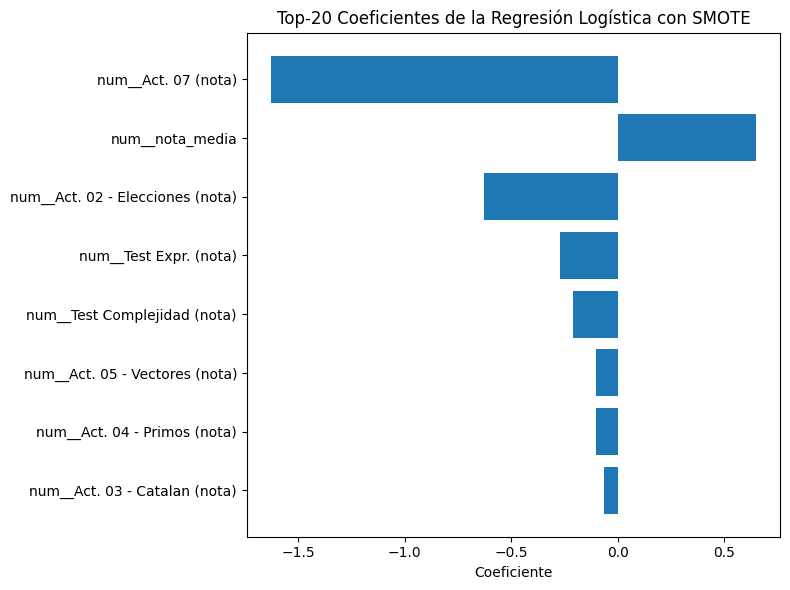

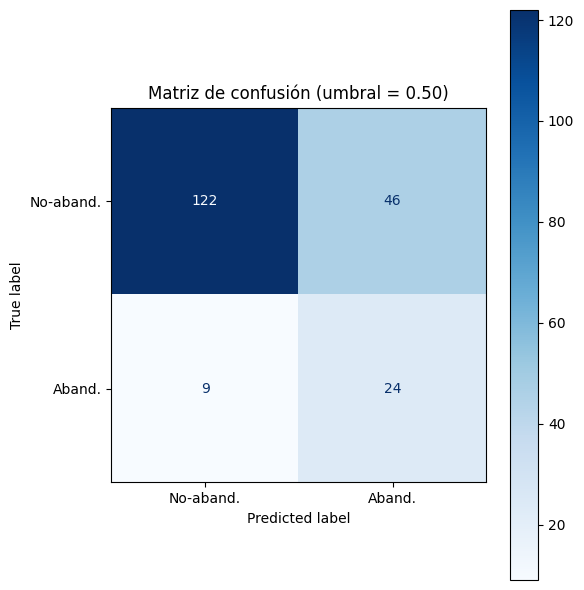

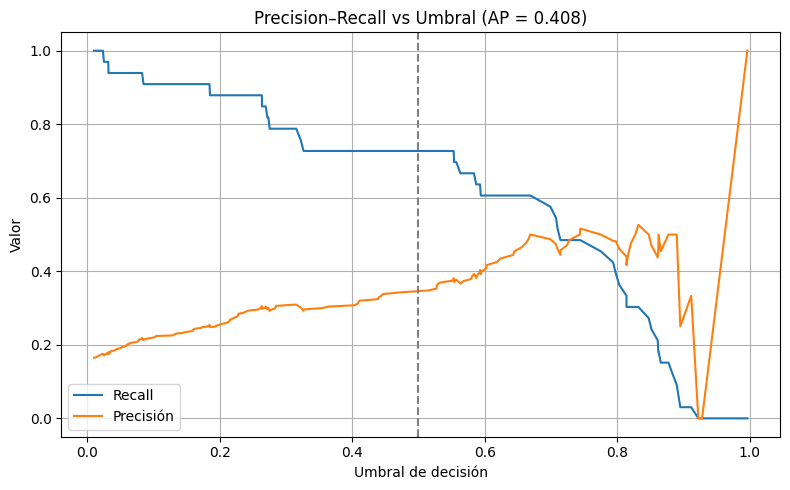

In [5]:
# %% [markdown]
# ### Logistic Regression + SMOTE: Coeficientes, matriz de confusión y curva P-R con CV

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# 1) Construir pipeline con SMOTE y semilla fija
pipe_smote = make_pipeline("LogReg", use_smote=True)
pipe_smote.named_steps["smote"].set_params(random_state=SEED)
pipe_smote.named_steps["clf"].set_params(random_state=SEED)

# 2) Obtener probabilidades fuera‐de‐muestra con CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
y_prob = cross_val_predict(
    pipe_smote, X, y,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]
y_pred = (y_prob >= 0.50).astype(int)

# 3) Mostrar coeficientes: entrena en todo el dataset
pipe_final = make_pipeline("LogReg", use_smote=True)
pipe_final.named_steps["smote"].set_params(random_state=SEED)
pipe_final.named_steps["clf"].set_params(random_state=SEED)
pipe_final.fit(X, y)

feature_names = pipe_final.named_steps["pre"].get_feature_names_out()
coef         = pipe_final.named_steps["clf"].coef_[0]
coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coef})
      .assign(abs_coef=lambda df: df.coef.abs())
      .sort_values("abs_coef", ascending=False)
      .reset_index(drop=True)
)

print("Top-20 coeficientes LR + SMOTE:")
display(coef_df.head(20)[["feature", "coef"]])

plt.figure(figsize=(8,6))
plt.barh(
    coef_df.head(20)["feature"][::-1],
    coef_df.head(20)["coef"][::-1]
)
plt.xlabel("Coeficiente")
plt.title("Top-20 Coeficientes de la Regresión Logística con SMOTE")
plt.tight_layout()
plt.show()

# 4) Matriz de confusión (threshold = 0.50)
cm = confusion_matrix(y, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No-aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title("Matriz de confusión (umbral = 0.50)")
plt.tight_layout()
plt.show()

# 5) Curva Precision-Recall vs. umbral
precision, recall, thresholds = precision_recall_curve(y, y_prob)
ap = average_precision_score(y, y_prob)

plt.figure(figsize=(8,5))
plt.plot(thresholds, recall[1:],    label="Recall")
plt.plot(thresholds, precision[1:], label="Precisión")
plt.axvline(0.50, color="grey", linestyle="--")
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.title(f"Precision–Recall vs Umbral (AP = {ap:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
